# bottleneck

In [1]:
# check them out
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

import numpy as np
import math

Using TensorFlow backend.


In [2]:
PATH_TO_DF = "../data/output_convnet/Inception"

img_width = 150
img_height = 150

n_epochs = 50
batch_size = 16

train_data_dir = "train"  
validation_data_dir = "validation"
test_data_dir = "test"

n_train_samples = 3000
n_validation_samples = 1000
n_test_samples = 1000
n_classes = 8

In [3]:
# https://b/log.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# saving bottleneck features
import time

ti_bn_features = time.time()

model = InceptionV3(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255)

'''
https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L1002
if PIL version 1.1.3 interpolation = 'lanczos'
else interpolation = 'bicubic' 
''' 

# train
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False,
    interpolation = 'lanczos')

# important step in order to get the exact number
max_queue_size_train = int(math.ceil(n_train_samples / batch_size))

bnfeatures_train = model.predict_generator(
    generator, max_queue_size_train)

np.save('../data/output_convnet/Inception/inception_bnfeatures_train.npy', bnfeatures_train)

# validation
generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    interpolation = 'lanczos')

max_queue_size_val = int(math.ceil(n_validation_samples / batch_size))


bnfeatures_val = model.predict_generator(  
     generator, max_queue_size_val)

np.save('../data/output_convnet/Inception/inception_bnfeatures_val.npy', bnfeatures_val)


tf_bn_features = time.time()    
tt_bn_features = tf_bn_features - ti_bn_features

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.


In [4]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_features)))

00:00:26


In [5]:
# training top layer
import os

ti_bn_train = time.time()

# we have to get the classes names so we build again a generator
datagen_top_layer = ImageDataGenerator(rescale=1./255)  

# train
generator_top_layer = datagen_top_layer.flow_from_directory(
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    shuffle=False,
    interpolation = 'lanczos')  

train_data = np.load('../data/output_convnet/Inception/inception_bnfeatures_train.npy')

# ref attribute classes --> https://keras.io/preprocessing/image/
train_labels = generator_top_layer.classes # the key attribute
train_labels = to_categorical(train_labels, num_classes=n_classes) # the key function

# validation
generator_top_layer = datagen_top_layer.flow_from_directory(  
    validation_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False,
    interpolation = 'lanczos')  

val_data = np.load('../data/output_convnet/Inception/inception_bnfeatures_val.npy') 

val_labels = generator_top_layer.classes # the key attribute
val_labels = to_categorical(val_labels, num_classes=n_classes) # the key function


# top model, could be with a diff dense, optimizer, momentum -> https://keras.io/optimizers/
model = Sequential()  
model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))  
model.add(Dense(1024, activation='relu'))  
model.add(Dense(n_classes, activation='softmax'))  

model.compile(optimizer=SGD(lr=0.001),
              loss='categorical_crossentropy', metrics=['accuracy']) 


historical_data = model.fit(train_data, train_labels,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(val_data, val_labels))  

# h5py
model.save_weights('../data/output_convnet/Inception/inception_bn_model.h5')  

tf_bn_train = time.time()    
tt_bn_train = tf_bn_train - ti_bn_train

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 2s 538us/step - loss: 1.7024 - acc: 0.3613 - val_loss: 1.4286 - val_acc: 0.5210
Epoch 2/50
3000/3000 [==============================] - 1s 327us/step - loss: 1.2423 - acc: 0.6540 - val_loss: 1.1950 - val_acc: 0.7050
Epoch 3/50
3000/3000 [==============================] - 1s 347us/step - loss: 1.0505 - acc: 0.7537 - val_loss: 1.0476 - val_acc: 0.7440
Epoch 4/50
3000/3000 [==============================] - 1s 336us/step - loss: 0.9254 - acc: 0.7967 - val_loss: 0.9515 - val_acc: 0.7600
Epoch 5/50
3000/3000 [==============================] - 1s 318us/step - loss: 0.8348 - acc: 0.8117 - val_loss: 0.8774 - val_acc: 0.7850
Epoch 6/50
3000/3000 [==============================] - 1s 319us/step - loss: 0.7648 - acc: 0.8213 - val_loss: 0.8265 - val_acc: 0.7930
Epoch 7/50
3000/3000 [==============================

In [6]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_train)))

00:00:50


In [7]:
import h5py
hdf5_file = h5py.File('../data/output_convnet/Inception/inception_bn_model.h5', mode='r')
print(list(hdf5_file))

['dense_1', 'dense_2', 'global_average_pooling2d_1']


In [8]:
(loss, acc) = model.evaluate(val_data, val_labels, batch_size=batch_size, verbose=0)
print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))  

acc: 84.40% - loss: 0.475641


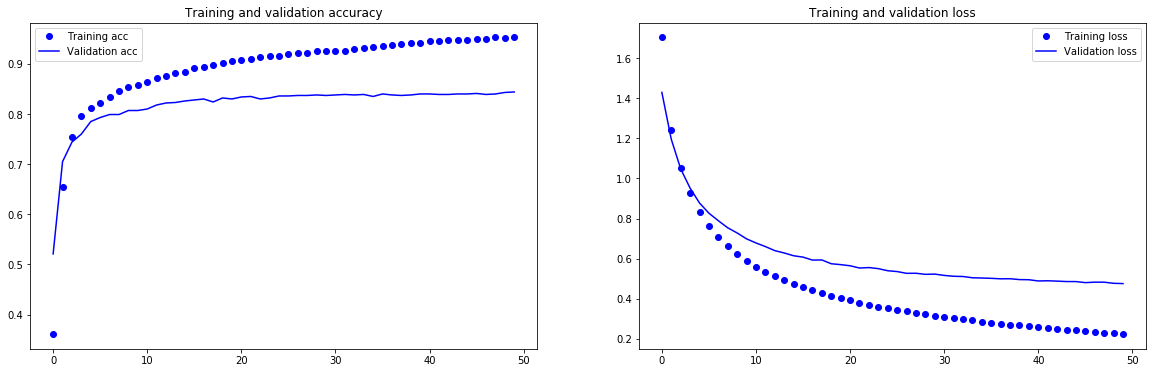

In [10]:
# historical_data.history acc and loss data over the epochs (train and validation)
import matplotlib.pyplot as plt

train_acc = historical_data.history['acc']
train_loss = historical_data.history['loss']

val_acc = historical_data.history['val_acc'] # validation
val_loss = historical_data.history['val_loss'] # validation

range_epochs = range(n_epochs)

fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plt.plot(range_epochs, train_acc, 'bo', label='Training acc')
plt.plot(range_epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1,2,2)
plt.plot(range_epochs, train_loss, 'bo', label='Training loss')
plt.plot(range_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig(os.path.join(PATH_TO_DF, "inception_bn_acc_loss.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb
plt.show()

# fine tuning

In [11]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input

In [12]:
top_model_weights_path = '../data/output_convnet/Inception/inception_bn_model.h5'
batch_size = 5 # con 5 funciona con 16 es imposible probar con 10

In [13]:
# base model
input_tensor = Input(shape=(img_width,img_height,3)) # another way to shape the input
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)

In [14]:
# top model
top_model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dense(8, activation='softmax'))

In [15]:
# base model has its weights, now we load the weights on the top layer
top_model.load_weights("../data/output_convnet/Inception/inception_bn_model.h5")

In [16]:
# we join base and top it has to be updated to api2
model_total = Model(input= base_model.input, output= top_model(base_model.output))

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [17]:
# sequential is the top layer a complex one
for i, layer in enumerate(model_total.layers):
    print (i, layer.name, layer.output_shape)

0 input_2 (None, 150, 150, 3)
1 conv2d_95 (None, 74, 74, 32)
2 batch_normalization_95 (None, 74, 74, 32)
3 activation_95 (None, 74, 74, 32)
4 conv2d_96 (None, 72, 72, 32)
5 batch_normalization_96 (None, 72, 72, 32)
6 activation_96 (None, 72, 72, 32)
7 conv2d_97 (None, 72, 72, 64)
8 batch_normalization_97 (None, 72, 72, 64)
9 activation_97 (None, 72, 72, 64)
10 max_pooling2d_5 (None, 35, 35, 64)
11 conv2d_98 (None, 35, 35, 80)
12 batch_normalization_98 (None, 35, 35, 80)
13 activation_98 (None, 35, 35, 80)
14 conv2d_99 (None, 33, 33, 192)
15 batch_normalization_99 (None, 33, 33, 192)
16 activation_99 (None, 33, 33, 192)
17 max_pooling2d_6 (None, 16, 16, 192)
18 conv2d_103 (None, 16, 16, 64)
19 batch_normalization_103 (None, 16, 16, 64)
20 activation_103 (None, 16, 16, 64)
21 conv2d_101 (None, 16, 16, 48)
22 conv2d_104 (None, 16, 16, 96)
23 batch_normalization_101 (None, 16, 16, 48)
24 batch_normalization_104 (None, 16, 16, 96)
25 activation_101 (None, 16, 16, 48)
26 activation_104 (None

In [18]:
for i, layer in enumerate(model_total.layers):
    if layer.trainable:
        print("layer {0:d}, {1:s} is trainable".format(i, layer.name))
    else:
        print("layer {0:d}, {1:s} is freezed".format(i, layer.name))

layer 0, input_2 is freezed
layer 1, conv2d_95 is trainable
layer 2, batch_normalization_95 is trainable
layer 3, activation_95 is trainable
layer 4, conv2d_96 is trainable
layer 5, batch_normalization_96 is trainable
layer 6, activation_96 is trainable
layer 7, conv2d_97 is trainable
layer 8, batch_normalization_97 is trainable
layer 9, activation_97 is trainable
layer 10, max_pooling2d_5 is trainable
layer 11, conv2d_98 is trainable
layer 12, batch_normalization_98 is trainable
layer 13, activation_98 is trainable
layer 14, conv2d_99 is trainable
layer 15, batch_normalization_99 is trainable
layer 16, activation_99 is trainable
layer 17, max_pooling2d_6 is trainable
layer 18, conv2d_103 is trainable
layer 19, batch_normalization_103 is trainable
layer 20, activation_103 is trainable
layer 21, conv2d_101 is trainable
layer 22, conv2d_104 is trainable
layer 23, batch_normalization_101 is trainable
layer 24, batch_normalization_104 is trainable
layer 25, activation_101 is trainable
laye

In [19]:
# freezing layers implies they will not update their weights over the training
# https://github.com/keras-team/keras/blob/master/keras/applications/inception_v3.py#L325
# tha's the key to the last conv layer
for layer in model_total.layers[:280]:
    layer.trainable = False
for layer in model_total.layers[280:]:
    layer.trainable = True

In [20]:
# check for updates
for i, layer in enumerate(model_total.layers):
    if layer.trainable:
        print("layer {0:d}, {1:s} is trainable".format(i, layer.name))
    else:
        print("layer {0:d}, {1:s} is freezed".format(i, layer.name))

layer 0, input_2 is freezed
layer 1, conv2d_95 is freezed
layer 2, batch_normalization_95 is freezed
layer 3, activation_95 is freezed
layer 4, conv2d_96 is freezed
layer 5, batch_normalization_96 is freezed
layer 6, activation_96 is freezed
layer 7, conv2d_97 is freezed
layer 8, batch_normalization_97 is freezed
layer 9, activation_97 is freezed
layer 10, max_pooling2d_5 is freezed
layer 11, conv2d_98 is freezed
layer 12, batch_normalization_98 is freezed
layer 13, activation_98 is freezed
layer 14, conv2d_99 is freezed
layer 15, batch_normalization_99 is freezed
layer 16, activation_99 is freezed
layer 17, max_pooling2d_6 is freezed
layer 18, conv2d_103 is freezed
layer 19, batch_normalization_103 is freezed
layer 20, activation_103 is freezed
layer 21, conv2d_101 is freezed
layer 22, conv2d_104 is freezed
layer 23, batch_normalization_101 is freezed
layer 24, batch_normalization_104 is freezed
layer 25, activation_101 is freezed
layer 26, activation_104 is freezed
layer 27, average_

In [21]:
model_total.compile(optimizer=SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# diff with bottleneck, we have to use data augmentation here
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1. / 255) # not in the val data

val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.


In [23]:
n_epochs = 5 # just for testing purposes
'''
some cells are run based only in 5 epoch just for testing purposes
the real weights were calculated with 50 epochs and will be loaded ahead
'''

'\nsome cells are run based only in 5 epoch just for testing purposes\nthe real weights were calculated with 50 epochs and will be loaded ahead\n'

In [24]:
import time
# fine-tune the model

ti_ftuning = time.time()


historical_data = model_total.fit_generator(
    train_generator,
    samples_per_epoch=n_train_samples,
    epochs=n_epochs,
    verbose = 1,
    validation_data=val_generator,
    validation_steps=n_validation_samples)

tf_ftuning = time.time()
tt_ftuning = tf_ftuning - ti_ftuning

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=5, verbose=1, validation_data=<keras.pre..., validation_steps=1000, steps_per_epoch=600)`
  del sys.path[0]


Epoch 1/5
600/600 [==============================] - 71s 119ms/step - loss: 1.2025 - acc: 0.5713 - val_loss: 2.0350 - val_acc: 0.6450
Epoch 2/5
600/600 [==============================] - 67s 112ms/step - loss: 1.0119 - acc: 0.6503 - val_loss: 2.1163 - val_acc: 0.6520
Epoch 3/5
600/600 [==============================] - 67s 112ms/step - loss: 0.9169 - acc: 0.6863 - val_loss: 2.3535 - val_acc: 0.6640
Epoch 4/5
600/600 [==============================] - 67s 111ms/step - loss: 0.8666 - acc: 0.7083 - val_loss: 2.6319 - val_acc: 0.6460
Epoch 5/5
600/600 [==============================] - 67s 111ms/step - loss: 0.8255 - acc: 0.7003 - val_loss: 2.5382 - val_acc: 0.6790


In [25]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_ftuning)))

00:05:40


In [26]:
model_total.save_weights('../data/output_convnet/Inception/inception_ft_testing_model.h5') # testing
# model_total.save_weights('../data/output_convnet/Inception/inception_ft_model.h5')

In [27]:
steps = int(math.ceil(n_validation_samples / batch_size))
(loss, acc) = model_total.evaluate_generator(val_generator, steps=steps)
print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))

acc: 67.90% - loss: 2.538239


In [28]:
train_acc = historical_data.history['acc']
train_loss = historical_data.history['loss']

val_acc = historical_data.history['val_acc'] # validation
val_loss = historical_data.history['val_loss'] # validation

print("train acc mean: {0:.2f} * train loss mean: {1:.2f}".format(np.average(train_acc),np.average(train_loss)))
print("validation acc mean: {0:.2f} * validation loss mean: {1:.2f}".format(np.average(val_acc),np.average(val_loss)))

train acc mean: 0.66 * train loss mean: 0.96
validation acc mean: 0.66 * validation loss mean: 2.33


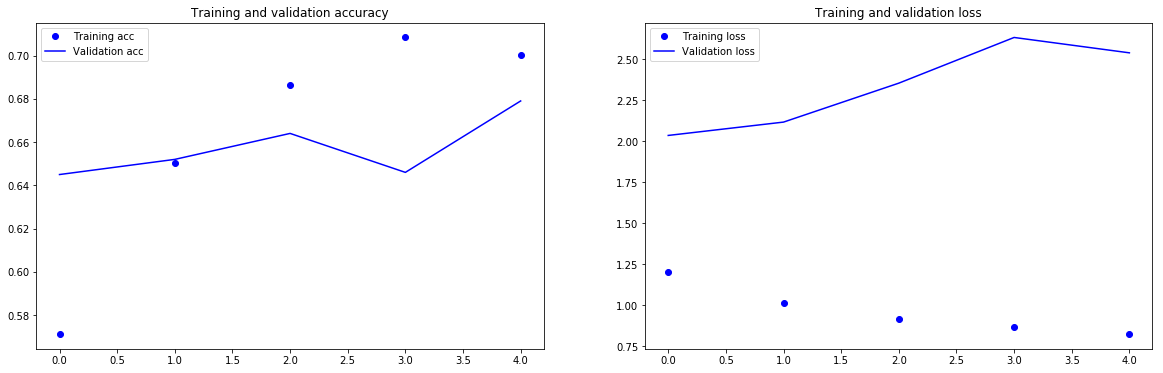

In [29]:
# historical_data.history acc and loss data over the epochs (train and validation)

range_epochs = range(n_epochs)

fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plt.plot(range_epochs, train_acc, 'bo', label='Training acc')
plt.plot(range_epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1,2,2)
plt.plot(range_epochs, train_loss, 'bo', label='Training loss')
plt.plot(range_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig(os.path.join(PATH_TO_DF, "VGG19_ft_testing_acc_loss.png"), bbox_inches='tight')
# plt.savefig(os.path.join(PATH_TO_DF, "VGG19_ft_acc_loss.png"), bbox_inches='tight')
plt.show()

In [31]:
# import h5py

# hdf5_file = h5py.File('../data/output_convnet/VGG19/VGG19_ft_model.h5', mode='r')

model_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)  

# top model
top_model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dense(8, activation='softmax'))

model_total = Model(input= base_model.input, output= top_model(base_model.output))

# loading the weights trained before
model_total.load_weights("../data/output_convnet/Inception/inception_ft_model.h5")

model_total.compile(optimizer=SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy']) 

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [32]:
test_convnet = ImageDataGenerator(rescale=1. / 255)

test_generator = test_convnet.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle =False,
    class_mode='categorical')

Found 1000 images belonging to 8 classes.


In [33]:
steps = int(math.ceil(n_test_samples / batch_size))

(loss, acc) = model_total.evaluate_generator(test_generator, steps=steps)

print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))

acc: 68.20% - loss: 2.811705


In [34]:
predictions = model_total.predict_generator(test_generator, steps = steps)

In [35]:
from sklearn.metrics import confusion_matrix

PATH_TO_IMG = "../data/input_dataset"

prediction_list = []
real_label_list = []

cat_dict = test_generator.class_indices # the key attribute
inverse_coding = {value: key for key, value in cat_dict.items()} # dict of categories

for label in test_generator.classes:
    real_label_list.append(inverse_coding[label])
    
for prediction in predictions:
    prediction_list.append(inverse_coding[np.argmax(prediction)])

# in order to get the confusion matrix
class_names = sorted([folder for folder in os.listdir(PATH_TO_IMG)
                  if os.path.isdir(os.path.join(PATH_TO_IMG, folder))])
prediction_list_arr = np.array(prediction_list) 
real_label_list_arr = np.array(real_label_list)

inception_cm_ft = confusion_matrix(real_label_list_arr,prediction_list_arr)

In [36]:
# reference http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)

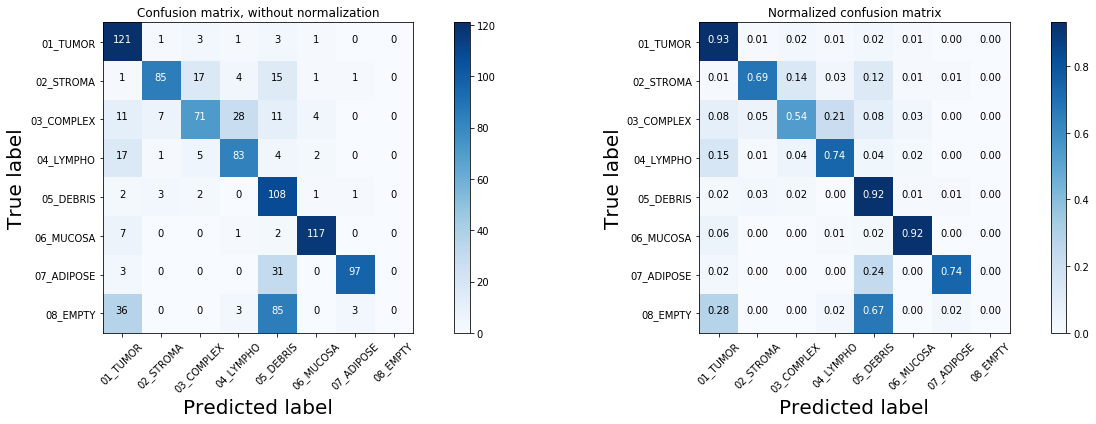

In [37]:
fig = plt.figure(figsize=(20, 6))


fig.add_subplot(1,2,1)
plot_confusion_matrix(inception_cm_ft, classes=class_names,
                      title='Confusion matrix, without normalization')

fig.add_subplot(1,2,2)
plot_confusion_matrix(inception_cm_ft, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig(os.path.join(PATH_TO_DF, "inception_ft_test.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()